# <center>Option Pricing Models</center>
### Kirill Zakharov
2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from functools import partial
from scipy.optimize import minimize

%matplotlib inline

plt.style.use('ggplot')

In [2]:
rvs = stats.norm.rvs(loc=0, scale=1, size=10000)

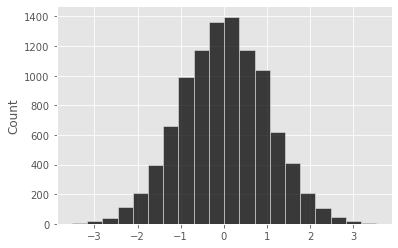

In [3]:
sns.histplot(rvs, color='black', bins=20)

plt.show()

## Main Class

In [334]:
class Stochastic_Models():
    
    def __init__(self, dividends=False):
        self.dividends = dividends
        
    def geometric_BM(self, t, initial, mu, sigma, dt):
        
        s = initial * np.exp((mu - (sigma**2)/2) * t + sigma * np.sqrt(dt) * stats.norm.rvs(loc=0, scale=1))
        
        return s
        
    def black_scholes(self, r, mu, sigma, strike, option_type='call', dividends=False, maturity=10, t=1, s0=0):
        
        if option_type == 'call':
            s = self.geometric_BM(t, s0, mu, sigma, 1)
            
            d1 = (np.log(s/strike) + (r + (sigma**2)/2) * (maturity - t)) / (sigma * np.sqrt(maturity - t))
            d2 = d1 - sigma * np.sqrt(maturity - t)
            
            c = s * stats.norm.cdf(d1, loc=0, scale=1) - strike * np.exp(-r * (maturity - t)) * stats.norm.cdf(d2, loc=0, scale=1)
        
        elif option_type == 'put':
            s = self.geometric_BM(t, initial, mu, sigma, 1)
            
            d1 = (np.log(s/strike) + (r + (sigma**2)/2) * (maturity - t)) / (sigma * np.sqrt(maturity - t))
            d2 = d1 - sigma * np.sqrt(maturity - t)
            
            c = strike * np.exp(-r * (maturity - t)) * stats.norm.cdf(-d2, loc=0, scale=1) - s * stats.norm.cdf(-d1, loc=0, scale=1)
            
        else:
            print('Incorrect type, available: call and put')
        
        return s, c
    
    def black_scholes_sim(self, r, mu, sigma, strike, option_type='call', dividends=False, maturity=10, s0=0):
        array = []
        
        for t in range(maturity):
            array.append(self.black_scholes(r, mu, sigma, strike, option_type, dividends, maturity, t, s0))
            
        return array    
    
    def heston(self, mu, theta, k, xi, rho, maturity, dt, v0, s0):
        v_array = np.zeros(maturity)
        s_array = np.zeros(maturity)
        
        v_array[0] = v0
        s_array[0] = s0
        
        for t in range(maturity - 1):
            dwv = stats.norm.rvs(loc=0, scale=1)
            dws = rho * dwv + np.sqrt(1 - rho**2) * stats.norm.rvs(loc=0, scale=1)
            
            v_array[t+1] = max(v_array[t] + k * (theta - v_array[t]) * dt + xi * np.sqrt(v_array[t]) * np.sqrt(dt) * dwv, 0)
            s_array[t+1] = max(s_array[t] + mu * s_array[t] * dt + np.sqrt(v_array[t+1]) * s_array[t] * np.sqrt(dt) * dws, 0)
            
        return s_array, v_array
    
#     def heston_option(self, muH, theta, k, xi, rho, v0, r, mu, sigma, strike, option_type='call', dividends=False, maturity=10, s0=0):
#         s, v = self.heston(muH, theta, k, xi, rho, maturity, dt, v0, s0)
#         c_array = []
        
#         for t in range(maturity):
            
#             d1 = (np.log(max(s[t]/strike, 1)) + (r + (sigma**2)/2) * (maturity - t)) / (sigma * np.sqrt(maturity - t))
#             d2 = d1 - sigma * np.sqrt(maturity - t)
            
#             c = s[t] * stats.norm.cdf(d1, loc=0, scale=1) - strike * np.exp(-r * (maturity - t)) * stats.norm.cdf(d2, loc=0, scale=1)
#             c_array.append(c)
            
#         return s, c_array   

    def heston_option(self, theta, k, xi, rho, v0, r, mu, strike, option_type='call', dividends=False, maturity=10, s0=0):
        s, v = self.heston(muH, theta, k, xi, rho, maturity, dt, v0, s0)
        c_array = []
        
        sigma = xi
        
        def d_fun(tau, u, indx):
                if indx == 1:
                    d = np.sqrt((rho * sigma * u * 1j - b1)**2 - sigma**2 * (2 * u1 * u * 1j - u**2))
                    
                    g = (b1 - rho * sigma * u * 1j + d)/(b1 - rho * sigma * u * 1j - d)
                    
                    res = (b1 - rho * sigma * u * 1j + d)/(sigma**2) * ((1 - g * np.exp(d*tau))/(1 - g))
                    return res
                
                elif indx == 2:
                    d = np.sqrt((rho * sigma * u * 1j - b2)**2 - sigma**2 * (2 * u2 * u * 1j - u**2))
                    
                    g = (b2 - rho * sigma * u * 1j + d)/(b2 - rho * sigma * u * 1j - d)
                    
                    res = (b2 - rho * sigma * u * 1j + d)/(sigma**2) * ((1 - g * np.exp(d*tau))/(1 - g))
                    return res
                
                else:
                    print('Wrong Index Number')
                    
        def c_fun(tau, u, indx):
                if indx == 1:
                    d = np.sqrt((rho * sigma * u * 1j - b1)**2 - sigma**2 * (2 * u1 * u * 1j - u**2))
                    
                    g = (b1 - rho * sigma * u * 1j + d)/(b1 - rho * sigma * u * 1j - d)
                    
                    res = r * 1j * u * tau + 1/sigma**2 * ((b1 - rho * sigma * u * 1j + d)*tau - 2*np.log((1 - g * np.exp(d*tau))/(1 - g)))
                    return res
                
                elif indx == 2:
                    d = np.sqrt((rho * sigma * u * 1j - b2)**2 - sigma**2 * (2 * u2 * u * 1j - u**2))
                    
                    g = (b2 - rho * sigma * u * 1j + d)/(b2 - rho * sigma * u * 1j - d)
                    
                    res = r * 1j * u * tau + 1/sigma**2 * ((b2 - rho * sigma * u * 1j + d)*tau - 2*np.log((1 - g * np.exp(d*tau))/(1 - g)))
                    return res
                
                else:
                    print('Wrong Index Number')
        
        for t in range(maturity):
            tau = maturity - t
            x = np.log(max(s[t], 1))
            
            u1 = 1/2
            u2 = -1/2
            
            lambda1 = 0.5
            
            b1 = k + lambda1 - rho * sigma
            b2 = k + lambda1
            
            f1 = lambda u: np.real((np.exp(-u * np.log(strike)) * np.exp(c_fun(tau, u, 1) + d_fun(tau, u, 1) * xi + 1j * u * x))/(1j*u))
            f2 = lambda u: np.real((np.exp(-u * np.log(strike)) * np.exp(c_fun(tau, u, 2) + d_fun(tau, u, 2) * xi + 1j * u * x))/(1j*u))
            
            p1 = 1/2 + 1/np.pi * quad(f1, 0, maturity)[0] #delta
            p2 = 1/2 + 1/np.pi * quad(f2, 0, maturity)[0] #probability at-the-money
            
            c = np.exp(x) * p1 - np.exp(-r * tau) * strike * p2
            
            c_array.append(c)
            
        return s, c_array, f1, p1
    
    def heston_option2(self, theta, k, xi, rho, v0, r, mu, strike, option_type='call', dividends=False, maturity=10, s0=100):
        s, v = self.heston(r, theta, k, xi, rho, maturity, dt, v0, s0)
        c_array = []
        
        sigma = xi
        
        for t in range(maturity):
            tau = maturity - t
            
            
            def f(x):
                M = np.sqrt((rho * sigma * x - k)**2 + sigma**2 * (x - x**2))
                
                N = (rho * sigma * x - k - M) / (rho * sigma * x - k + M)
                
                A = r * x * tau + k * theta / sigma**2 * (-(rho * sigma * x - k - M) * tau - 2*np.log((1 - N * np.exp(M * tau))/(1 - N)))
                
                C = ((np.exp(M * tau) - 1) * (rho * sigma * x - k - M)) / (sigma**2 * (1 - N * np.exp(M * tau)))
                
                return np.exp(A + C * v[t] + x * s[t])
            
            c = 1/2 * s[t] + (np.exp(-r * tau))/np.pi *  quad(lambda u: np.real( (strike**(-1j * u) * f(1j * u + 1)) / (1j * u) ), \
                                                              0, np.inf, maxp1=50, limit=100)[0] - \
                    strike * np.exp(-r * tau) * (1/2 + 1/np.pi * quad(lambda u: np.real( (strike**(-1j * u) * f(1j * u)) / (1j * u) ), \
                                                                      0, np.inf, maxp1=50, limit=100)[0])
            
            c_array.append(max(c, 0))
            
        return s, c_array
    
    def lewis_approximation(self, theta, k, xi, rho, v0, r, mu, strike, option_type='call', dividends=False, maturity=10, s0=0):
        s, v = self.heston(r, theta, k, xi, rho, maturity, dt, v0, s0)
        c_array = []
        
        sigma = xi
        
        
        for t in range(maturity):
            tau = maturity - t
            
            x = np.log(s[t]/strike) + r * tau
            
            def h_fun(k, v, tau):
                
                b = 2/sigma**2 * (1j * k * rho * sigma + k)
            
                l = np.sqrt(b**2 + (4*(k**2 - 1j * k))/sigma**2)

                q = sigma**2 * tau/2

                h = (b - l)/(b + l)

                g = (b - l)/2
                
                return np.exp(2 * k * theta/sigma**2 * (q * g - np.log((1 - h * np.exp(-l * q))/(1 - h)) + v * g * (1 - np.exp(-l * q))/(1 - h * np.exp(-l*q))))
            
            fun = lambda k: np.real(np.exp(-k * x * 1j) * h_fun(k, v[t], tau) / (k**2 - 1j * k))
            
            c = s[t] - strike * np.exp(-r * tau) * 1/np.pi * quad(fun, -np.inf, np.inf, maxp1=50, limit=100)[0]
            
            c_array.append(c)
            
            return s, c_array
    
    def simulation(self, model, maturity):
        array = []
        
        for t in range(maturity):
            array.append(model)
            
        return array
    
    def path_plot(self, values, name='Path'):
        
        plt.subplots(figsize=(10, 5), dpi=120)
        plt.plot(values[0], label='Underlying Asset')
        plt.plot(values[1], label='Option Price')
        
        plt.title(name, fontsize=16)
        plt.legend()
        plt.show()

In [335]:
model = Stochastic_Models()

### Initial Parameters

In [309]:
mu = 0.1
sigma = 0.2
dt = 1
maturity = 14
r = 0.08

strike = 150
initial = 100
option_type = 'call'
dividends = False

### Simulation

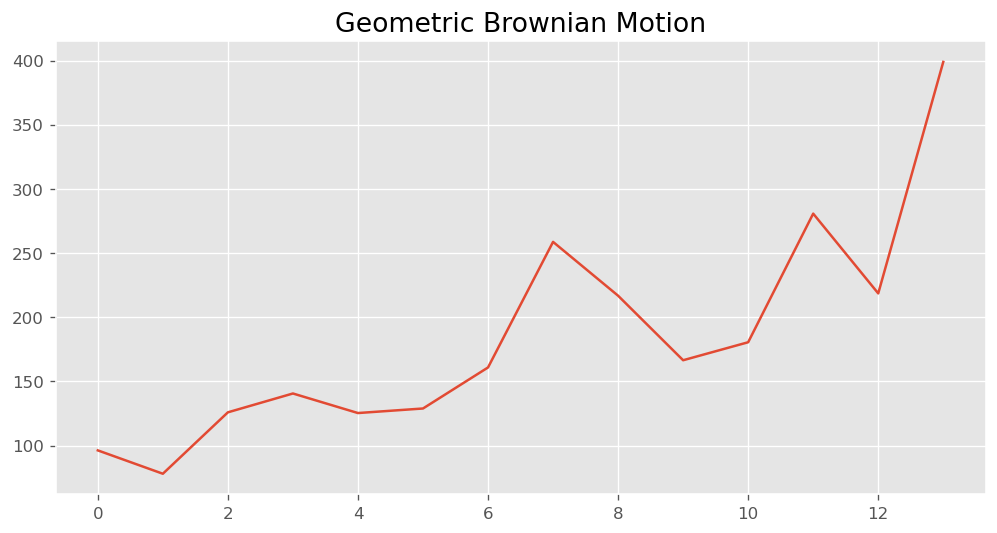

In [310]:
geom_motion = []
for t in range(maturity):
    geom_motion.append(model.geometric_BM(t, initial, mu, sigma, dt))
    
plt.subplots(figsize=(10, 5), dpi=120)
plt.plot(geom_motion)
plt.title('Geometric Brownian Motion', fontsize=16)
plt.show()

In [311]:
array= []
for t in range(10):
    array.append(model.black_scholes(r, mu, sigma, strike, option_type, dividends, maturity, t, initial))
    
array = np.array(array).T

In [312]:
blackScholesSim = model.black_scholes_sim(r, mu, sigma, strike, option_type, dividends, maturity, initial)
blackScholesSim = np.array(blackScholesSim).T

### Visualisation

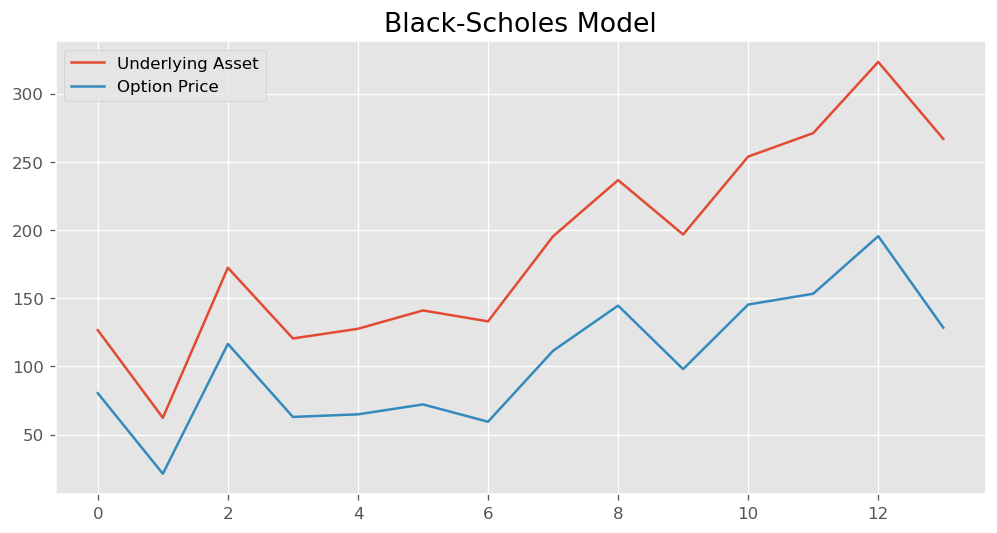

In [313]:
model.path_plot(blackScholesSim, 'Black-Scholes Model')

In [314]:
mu = 0.04
dt = 1
maturity = 14
k = 3
theta = 0.05
xi = 0.02
v0 = 0.05
s0 = 100
rho = 0.5

In [315]:
hestonSim = model.heston(mu, theta, k, xi, rho, maturity, dt, v0, s0)

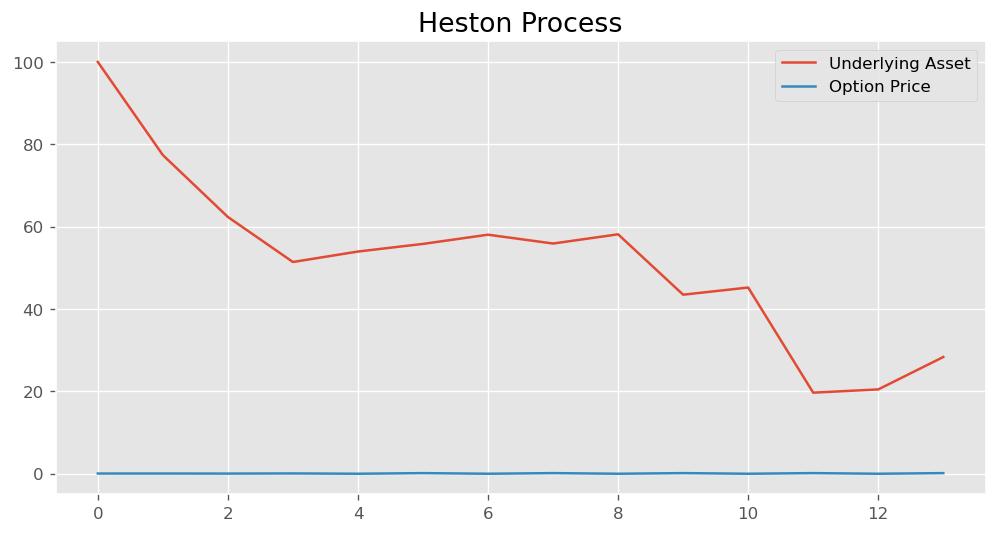

In [316]:
model.path_plot(hestonSim, 'Heston Process')

In [317]:
mu = 0.04
sigma = 0.2
r = 0.04

strike = 1.5
s0 = 1
option_type = 'call'
dividends = False

dt = 1
maturity = 14
k = 0.2
theta = 0.05
xi = 0.002
v0 = 0.05
rho = 0.5

In [318]:
hestonSim = model.heston_option2(theta, k, xi, rho, v0, r, mu, strike, option_type, dividends, maturity, s0)

In [319]:
hestonSim

(array([1.        , 1.12027383, 0.72201877, 0.74805537, 0.89036947,
        0.7793178 , 0.74423218, 0.84878629, 0.89314707, 1.25440286,
        1.6520525 , 1.66625429, 1.64356501, 1.52728274]),
 [1.0479925995727333,
  1.235443527463222,
  0.5424693171349075,
  0.5403444820776978,
  0.711694046238122,
  0.5016056503615555,
  0.4068119268819588,
  0.5092210613532707,
  0.5266674474114366,
  1.1582749056760058,
  2.1568878920874575,
  2.148942455669159,
  2.023900767305321,
  1.6252797434570552])

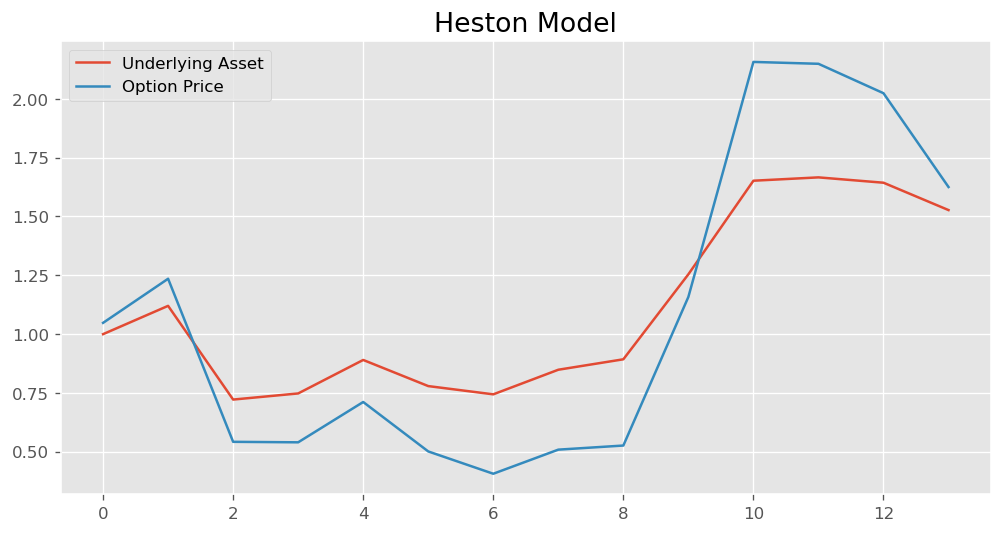

In [320]:
model.path_plot(hestonSim, 'Heston Model')

In [321]:
2*k*theta >= xi**2 # if True then vt  is strictly positive

True

In [340]:
mu = 0.04
sigma = 0.02
r = 0.04

strike = 1.2
s0 = 0.3
option_type = 'call'
dividends = False

dt = 1
maturity = 14
k = 2
theta = 0.05
xi = 0.002
v0 = 0.05
rho = 0.5

In [341]:
model.lewis_approximation(theta, k, xi, rho, v0, r, mu, strike, option_type, dividends, maturity, s0)

<ipython-input-334-416f70d40197>:197: RuntimeWarning: overflow encountered in exp
  return np.exp(2 * k * theta/sigma**2 * (q * g - np.log((1 - h * np.exp(-l * q))/(1 - h)) + v * g * (1 - np.exp(-l * q))/(1 - h * np.exp(-l*q))))
<ipython-input-334-416f70d40197>:199: RuntimeWarning: invalid value encountered in cdouble_scalars
  fun = lambda k: np.real(np.exp(-k * x * 1j) * h_fun(k, v[t], tau) / (k**2 - 1j * k))
<ipython-input-334-416f70d40197>:201: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  c = s[t] - strike * np.exp(-r * tau) * 1/np.pi * quad(fun, -np.inf, np.inf, maxp1=50, limit=100)[0]


(array([0.3       , 0.32637538, 0.25203321, 0.27941831, 0.17939627,
        0.1816375 , 0.15556433, 0.13912631, 0.13013584, 0.15152953,
        0.13987144, 0.11584893, 0.118389  , 0.10615529]),
 [nan])

## Fast Fourier Transform

In [352]:
fft([2,3])

array([ 5.-0.j, -1.-0.j])

In [353]:
def fft_cf(K, S0, r, T, cf): # interp support cubic 
    """ 
    K = vector of strike
    S0 = spot price scalar
    cf = characteristic function
    """
    N=2**15                         # FFT more efficient for N power of 2
    B = 500                         # integration limit 
    
    dx = B/N
    x = np.arange(N) * dx

    weight = 3 + (-1)**(np.arange(N)+1) # Simpson weights
    weight[0] = 1; weight[N-1]=1

    dk = 2*np.pi/B
    b = N * dk /2
    ks = -b + dk * np.arange(N)

    integrand = np.exp(- 1j * b * np.arange(N)*dx) * cf(x - 0.5j) * 1/(x**2 + 0.25) * weight * dx/3
    integral_value = np.real( ifft(integrand)*N )
    spline_cub = interp1d(ks, integral_value, kind="cubic") # cubic will fit better than linear
    prices = S0 - np.sqrt(S0 * K) * np.exp(-r*T)/np.pi * spline_cub( np.log(S0/K) )
    
    return prices

In [354]:
def cf_normal(u, mu=0, sigma=1):
            return np.exp( 1j * u * mu - 0.5 * u**2 * sigma**2 )

In [355]:
fft_cf(np.array([26400, 30000]), 25500, 0.0226, 14, lambda u: cf_normal(u, (r - 0.5 * sigma**2) * maturity, sigma * np.sqrt(maturity) ))

array([6260.52784384, 3636.96347804])

In [356]:
def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
            xi = kappa - sigma*rho*u * 1j
            d = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j * u) )
            g1 = (xi+d)/(xi-d)
            g2 = 1/(g1 + 1e-15)
            cf = np.exp( 1j * u*mu*t + (kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g2*np.exp(-d*t))/(1-g2) ))\
                      + (v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g2*np.exp(-d*t)) )
            return cf

In [357]:
fft_cf(np.array([26400, 30000]), 25500, 0.0226, 14, lambda u: cf_Heston_good(u, maturity, v0, mu, k, theta, sigma, rho))

array([9473.37294938, 8027.04023378])

## Calibration

In [346]:
data = pd.read_csv('sp500_option.csv')
data = data.iloc[:-1,:]

In [347]:
data = data[['Strike', 'Bid', 'Midpoint', 'Ask']]
data['Strike'] = (data['Strike'].apply(lambda x: x.replace(',', ''))).astype(float)

In [348]:
data

,Strike,Bid,Midpoint,Ask
0,4205.0,309.6,312.05,314.5
1,4210.0,300.4,305.60,310.8
2,4215.0,300.2,305.35,310.5
3,4220.0,290.2,295.75,301.3
4,4225.0,289.5,296.35,303.2
...,...,...,...,...
195,4680.0,240.4,242.90,245.4
196,4685.0,239.8,247.90,256.0
197,4690.0,250.0,252.55,255.1
198,4695.0,254.1,256.45,258.8


In [349]:
data['Spread'] = data['Ask'] - data['Bid']

In [350]:
data.head()

,Strike,Bid,Midpoint,Ask,Spread
0,4205.0,309.6,312.05,314.5,4.9
1,4210.0,300.4,305.60,310.8,10.4
2,4215.0,300.2,305.35,310.5,10.3
3,4220.0,290.2,295.75,301.3,11.1
4,4225.0,289.5,296.35,303.2,13.7


In [358]:
def Feller(x):
    return 2*x[1] * x[2] - x[3]**2 - 1e-6
cons = ({"fun": Feller, "type": "ineq"})

def error_f(x, prices, strike, spread):
    
    price_calib = fft_cf(np.array(strike), 300, 0.0426, maturity, lambda u: cf_Heston_good(u, maturity, v0, x[0], x[1], x[2], x[3], x[4]))
    
    return sum(((price_calib - prices)/spread)**2)


prices = data['Midpoint']
strikes = data['Strike']
spreads = data['Spread']

init_vals = [mu, k, theta, xi, rho]
bounds = ((-1, 1), (-10, 100), (-100, 100), (0, 100), (-1, 1))

params_Hest_con = minimize(error_f, x0=init_vals, args=(prices, strikes, spreads),
                  bounds=bounds, tol=1e-5, constraints=cons, options={"maxiter": 5000})

# Result
params_Hest_con

     fun: 916076.5491959479
     jac: array([ 8.76175955e+07,  3.42981250e+03, -2.11914561e+06, -8.84626875e+04,
       -3.54732031e+03])
 message: 'Inequality constraints incompatible'
    nfev: 6
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0.04 , 2.   , 0.05 , 0.002, 0.5  ])

In [361]:
paramaters_estimation = params_Hest_con.x

In [359]:
fft_cf(np.array(strike), 4000, 0.0426, maturity, lambda u: cf_Heston_good(u, maturity, v0, 0.1, 0.2, 2, 0.5, 0.5))

3999.5868003133523

## Calibration with Heston Model

In [404]:
# def Feller(x):
#     return 2*x[1] * x[2] - x[3]**2 - 1e-6
# cons = ({"fun": Feller, "type": "ineq"})

def error_f(x, prices, strike, spread):
    
    price_calib = model.heston_option2(x[2], x[1], x[3], x[4], v0, r, x[0], strike[0]/1000, option_type, dividends, len(prices), 4)
    
    return sum(((price_calib[1] - prices/1000)/spread)**2)


prices = data['Midpoint'].iloc[:50]
strikes = data['Strike'].iloc[:50]
spreads = data['Spread'].iloc[:50]

init_vals = [mu, k, theta, xi, rho]
bounds = ((0.0001, 1), (0.0001, 1), (0.0001, 1), (0.01, 0.5), (-1, 1))

params_Hest_con = minimize(error_f, x0=init_vals, args=(prices, strikes, spreads),
                  bounds=bounds, tol=1e-10, options={"maxiter": 2000})

# Result
params_Hest_con

<ipython-input-334-416f70d40197>:158: RuntimeWarning: overflow encountered in exp
  A = r * x * tau + k * theta / sigma**2 * (-(rho * sigma * x - k - M) * tau - 2*np.log((1 - N * np.exp(M * tau))/(1 - N)))
<ipython-input-334-416f70d40197>:158: RuntimeWarning: invalid value encountered in cdouble_scalars
  A = r * x * tau + k * theta / sigma**2 * (-(rho * sigma * x - k - M) * tau - 2*np.log((1 - N * np.exp(M * tau))/(1 - N)))
<ipython-input-334-416f70d40197>:160: RuntimeWarning: overflow encountered in exp
  C = ((np.exp(M * tau) - 1) * (rho * sigma * x - k - M)) / (sigma**2 * (1 - N * np.exp(M * tau)))
<ipython-input-334-416f70d40197>:160: RuntimeWarning: invalid value encountered in cdouble_scalars
  C = ((np.exp(M * tau) - 1) * (rho * sigma * x - k - M)) / (sigma**2 * (1 - N * np.exp(M * tau)))
<ipython-input-334-416f70d40197>:160: RuntimeWarning: invalid value encountered in multiply
  C = ((np.exp(M * tau) - 1) * (rho * sigma * x - k - M)) / (sigma**2 * (1 - N * np.exp(M * tau)))
<

KeyboardInterrupt: 

In [398]:
# def Feller(x):
#     return 2*x[1] * x[2] - x[3]**2 - 1e-6
# cons = ({"fun": Feller, "type": "ineq"})

def error_f(x, prices, strike, spread):
    blackScholesSim = model.black_scholes_sim(r, x[0], x[1], strike[0]/1000, option_type, dividends, len(prices), 4)
    blackScholesSim = np.array(blackScholesSim).T
    
    price_calib = blackScholesSim[1]
    
    return sum(((price_calib[1] - prices/1000)/spread)**2)


prices = data['Midpoint'].iloc[:50]
strikes = data['Strike'].iloc[:50]
spreads = data['Spread'].iloc[:50]

init_vals = [mu, sigma]
bounds = ((0.0001, 1), (0.0001, 1))

params_BS = minimize(error_f, x0=init_vals, args=(prices, strikes, spreads),
                  bounds=bounds, tol=1e-10, options={"maxiter": 2000})

params_BS

      fun: 93.36677358305954
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.56737829e+08, -8.83821468e+08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 2
     njev: 19
   status: 0
  success: True
        x: array([0.04000005, 0.02000003])

In [399]:
params_BS = params_BS.x
params_BS

array([0.04000005, 0.02000003])

In [401]:
blackScholesSim = model.black_scholes_sim(r, params_BS[0], params_BS[1], strikes[0]/1000, option_type, dividends, maturity, 4)
blackScholesSim = np.array(blackScholesSim).T

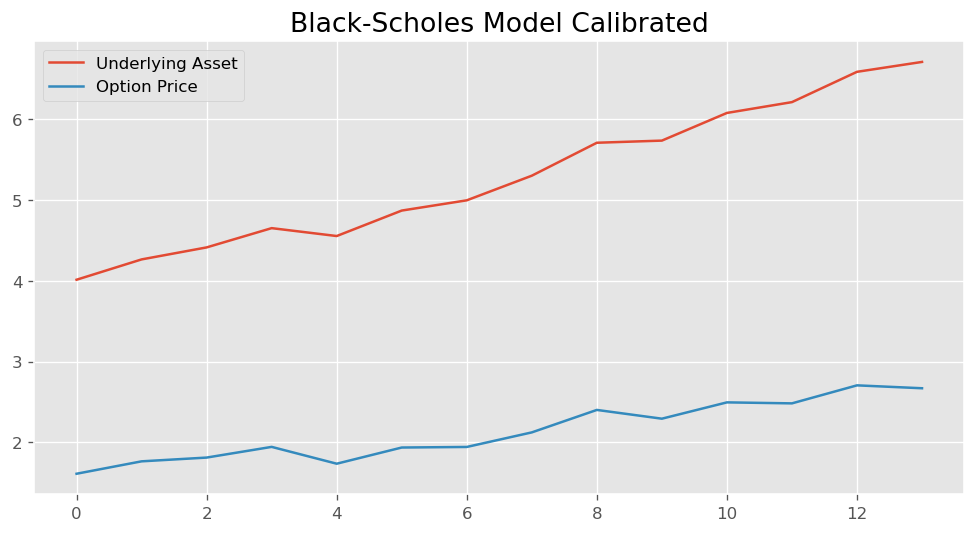

In [403]:
model.path_plot(blackScholesSim, 'Black-Scholes Model Calibrated')